### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [3]:
from src.load_datasets import load_air_polution_data

dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_data, freq="H")
)

print(f"dataframe shape {dataframe.shape}")

# dataframe = dataframe.tail(515)

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (43800, 7)
dataframe shape (43800, 7)


,pollution,dewp,temp,press,wnd_spd,snow,rain
Date_Time,,,,,,,
2010-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,1.79,0.0,0.0
2010-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.68,0.0,0.0
2010-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,3.57,0.0,0.0
2010-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,5.36,1.0,0.0
2010-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,6.25,2.0,0.0


In [4]:
dataframe.isna().sum()

pollution    0
dewp         0
temp         0
press        0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [5]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

,pollution,dewp,temp,press,wnd_spd,snow,rain
pollution,1.000000,0.157731,-0.099956,-0.035189,-0.242691,0.018864,-0.052134
dewp,0.157731,1.000000,0.824432,-0.778737,-0.296720,-0.034484,0.125053
temp,-0.099956,0.824432,1.000000,-0.827205,-0.154902,-0.092726,0.049037
press,-0.035189,-0.778737,-0.827205,1.000000,0.185380,0.069031,-0.079840
wnd_spd,-0.242691,-0.296720,-0.154902,0.185380,1.000000,0.021876,-0.010137
snow,0.018864,-0.034484,-0.092726,0.069031,0.021876,1.000000,-0.009553
rain,-0.052134,0.125053,0.049037,-0.079840,-0.010137,-0.009553,1.000000


### Test Train split

train_xy and test_xy size: (43785, 7), (15, 7)

y_train and x_train size (43785,), (43785, 6)
y_test  and x_test  size (15,),  (15, 6)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

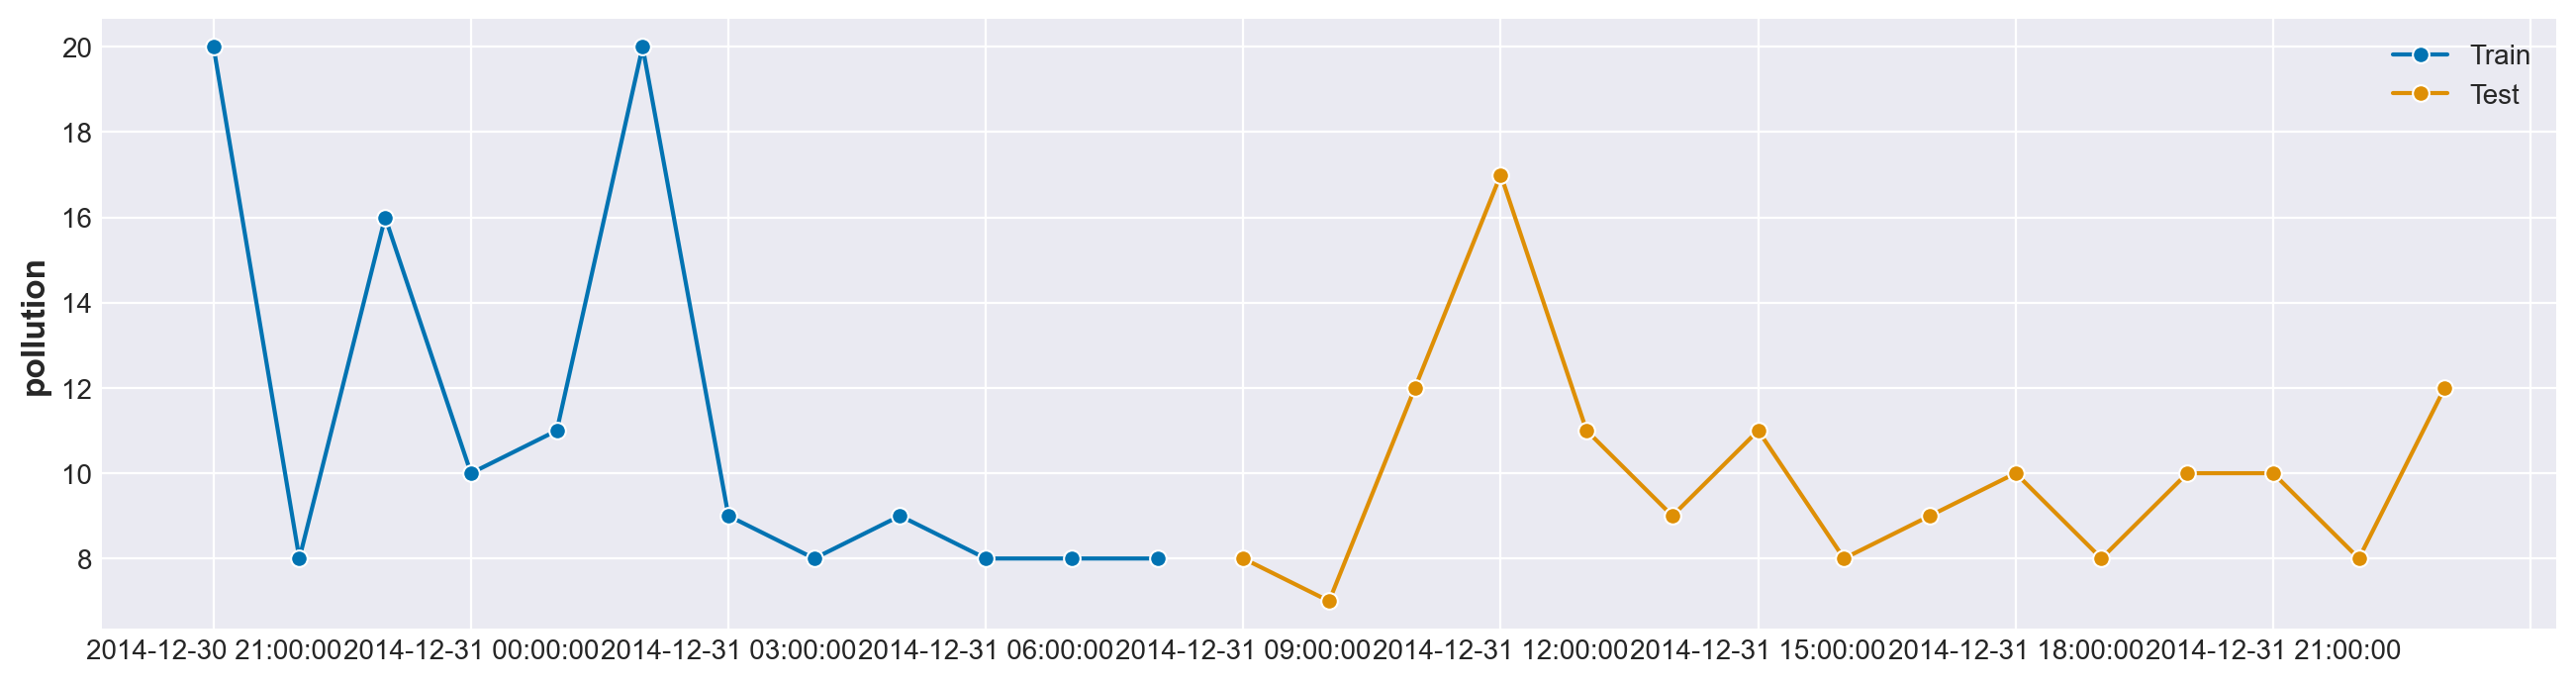

In [6]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "pollution"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(12), y_test, labels=["Train", "Test"])

#### Huyper Parameter Selection 

intital_window_size 43710 , step_length 15 for fold 5


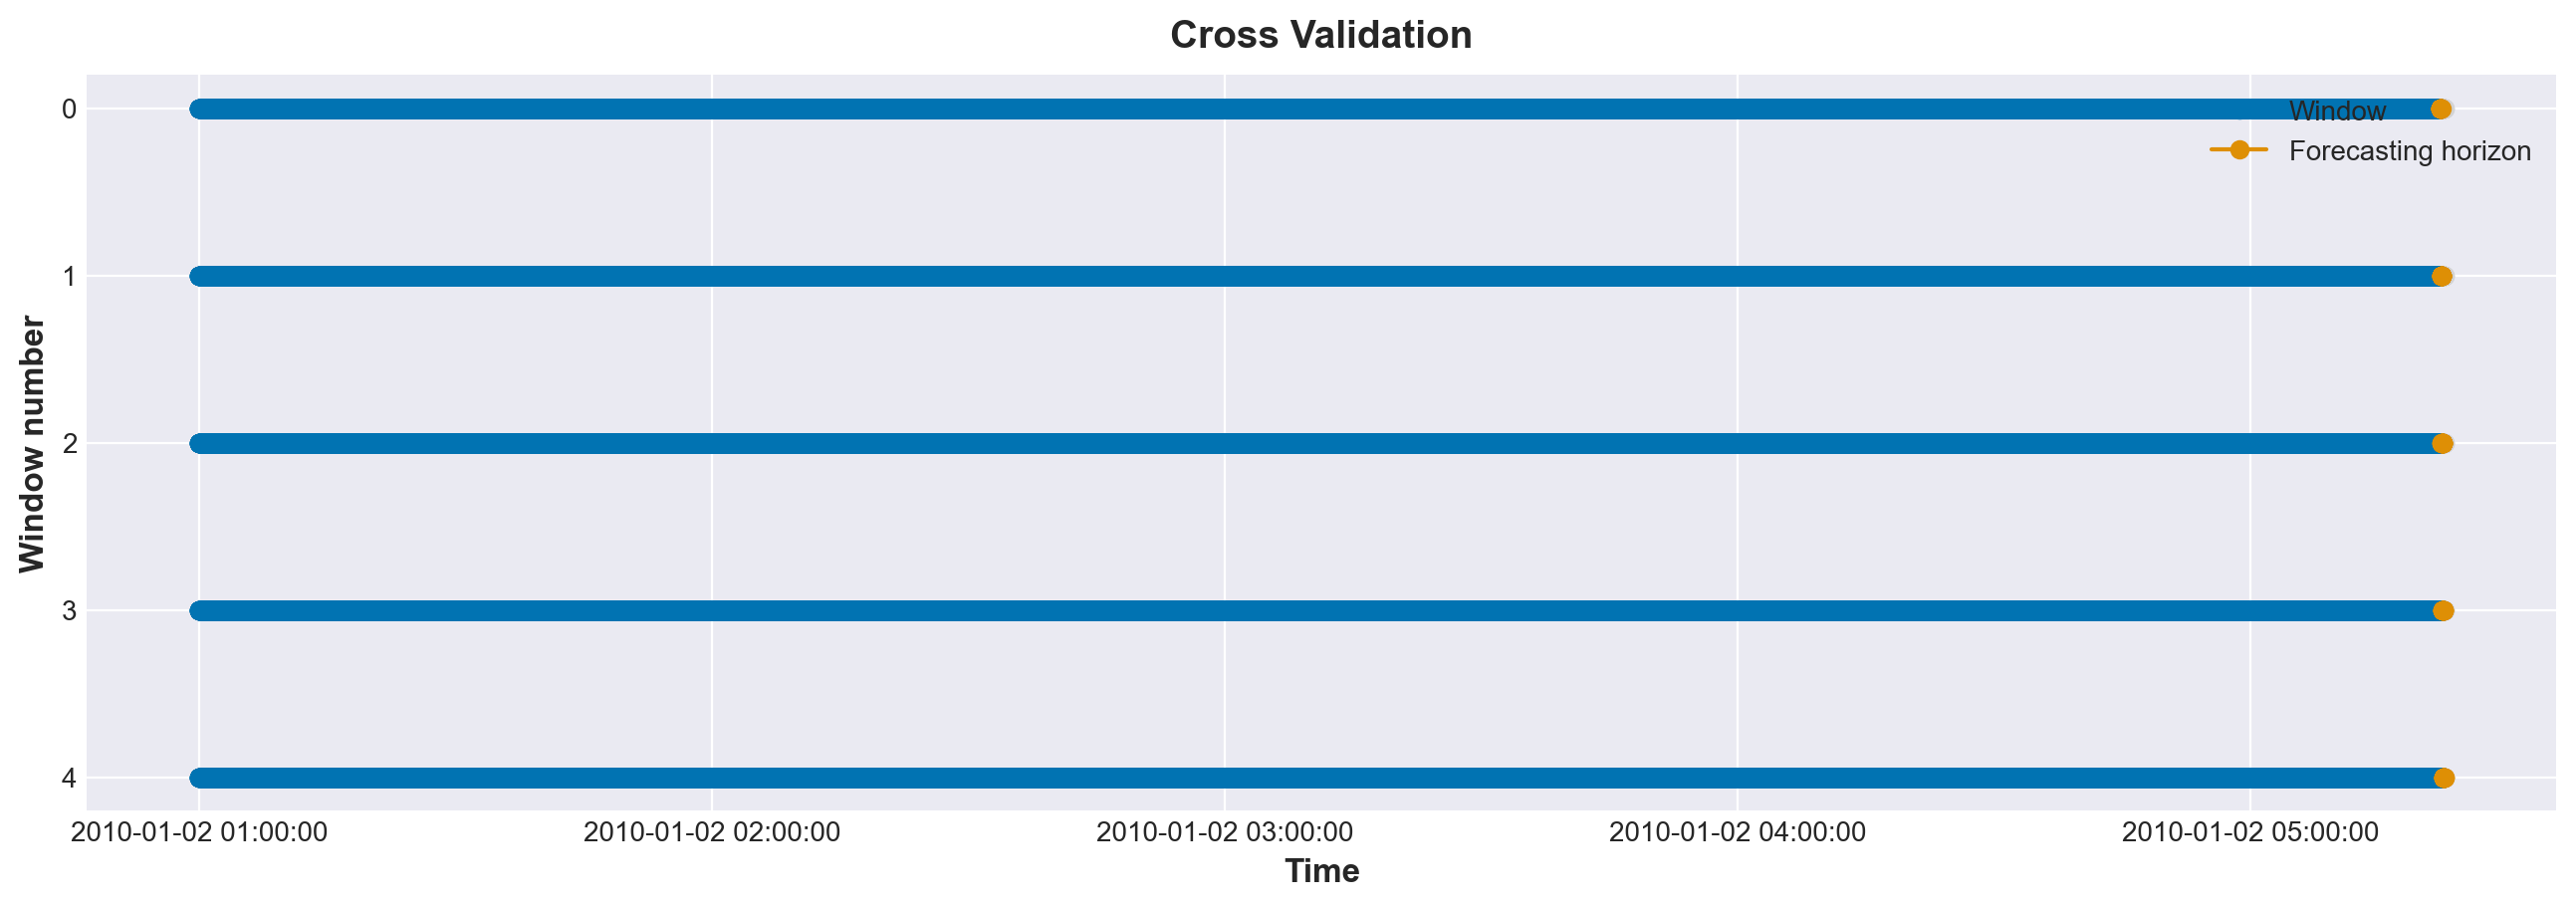

In [7]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

y_size = len(y_train)

fold = 5

step_length = len(fh)

fh_max_length = max(fh)

intital_window_size = y_size - ((fold - 1) * step_length + 1 * fh_max_length)

# intital_window_size = int(y_train.shape[0] * 0.80)

print(
    f"intital_window_size {intital_window_size} , step_length {step_length} for fold {fold}"
)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

plot_windows(cv, y_train, title="Cross Validation")

In [8]:
%%time

from sklearn.preprocessing import MinMaxScaler

try:
    from sklearnex.linear_model import LassoLars

    print("Importing sklearnex LassoLars")
except ImportError:
    print("Failed to import LassoLars from sklearnex")
    from sklearn.linear_model import LassoLars

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import (
    Detrender,
    Deseasonalizer,
    ConditionalDeseasonalizer,
)
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsoluteError

param_grid = {
    # "forecaster__deseasonalizer__model": ["additive", "multiplicative"],
    "scaler_x__passthrough": [True, False],
    "forecaster__deseasonalizer__model": ["additive"],
    "forecaster__deseasonalizer__sp": [24],
    "forecaster__detrender__forecaster__degree": [1, 2],
    "forecaster__reducer__window_length": [24],
    "forecaster__reducer__estimator__fit_intercept": [True, False],
    "forecaster__reducer__estimator__alpha": [0.01, 0.1, 1, 10],
    "forecaster__reducer__estimator__eps": [0.0001, 0.001, 0.01, 0.1],
}

forecaster_pipe = ForecastingPipeline(
    steps=[
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        (
            "scaler_x",
            OptionalPassthrough(
                TabularToSeriesAdaptor(MinMaxScaler()), passthrough=False
            ),
        ),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    (
                        "deseasonalizer",
                        ConditionalDeseasonalizer(model="additive", sp=24),
                    ),
                    (
                        "detrender",
                        Detrender(forecaster=PolynomialTrendForecaster(degree=1)),
                    ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=LassoLars(random_state=80),
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="global",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

print(f"Number of CPU Count:   {os.cpu_count()}")

n_cpu = os.cpu_count() - 1 if os.cpu_count() > 2 else 1

gscv = ForecastingGridSearchCV(
    forecaster_pipe,
    strategy="refit",
    scoring=MeanAbsoluteError(),
    cv=cv,
    param_grid=param_grid,
    verbose=10,
    n_jobs=n_cpu,
    refit=True,
    error_score="raise",
)

gscv.fit(y_train, X=x_train, fh=fh)

print("Best Params", gscv.best_params_)
print("Best scores", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)

Failed to import LassoLars from sklearnex
Number of CPU Count:   12
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best Params {'forecaster__deseasonalizer__model': 'additive', 'forecaster__deseasonalizer__sp': 24, 'forecaster__detrender__forecaster__degree': 2, 'forecaster__reducer__estimator__alpha': 0.01, 'forecaster__reducer__estimator__eps': 0.0001, 'forecaster__reducer__estimator__fit_intercept': False, 'forecaster__reducer__window_length': 24, 'scaler_x__passthrough': True}
Best scores 66.23479522438699
CPU times: total: 6.45 s
Wall time: 3min 35s


In [9]:
print(x_test.columns)

Index(['dewp', 'temp', 'press', 'wnd_spd', 'snow', 'rain'], dtype='object')


2014-12-31 09:00:00     8.015774
2014-12-31 10:00:00     8.268204
2014-12-31 11:00:00     7.160941
2014-12-31 12:00:00     4.507830
2014-12-31 13:00:00     0.585743
2014-12-31 14:00:00    -4.613175
2014-12-31 15:00:00    -8.455651
2014-12-31 16:00:00   -10.826689
2014-12-31 17:00:00   -10.833312
2014-12-31 18:00:00    -8.788838
2014-12-31 19:00:00    -4.671515
2014-12-31 20:00:00     1.443423
2014-12-31 21:00:00     5.201110
2014-12-31 22:00:00     6.970142
2014-12-31 23:00:00     7.796367
Freq: H, Name: pollution, dtype: float64

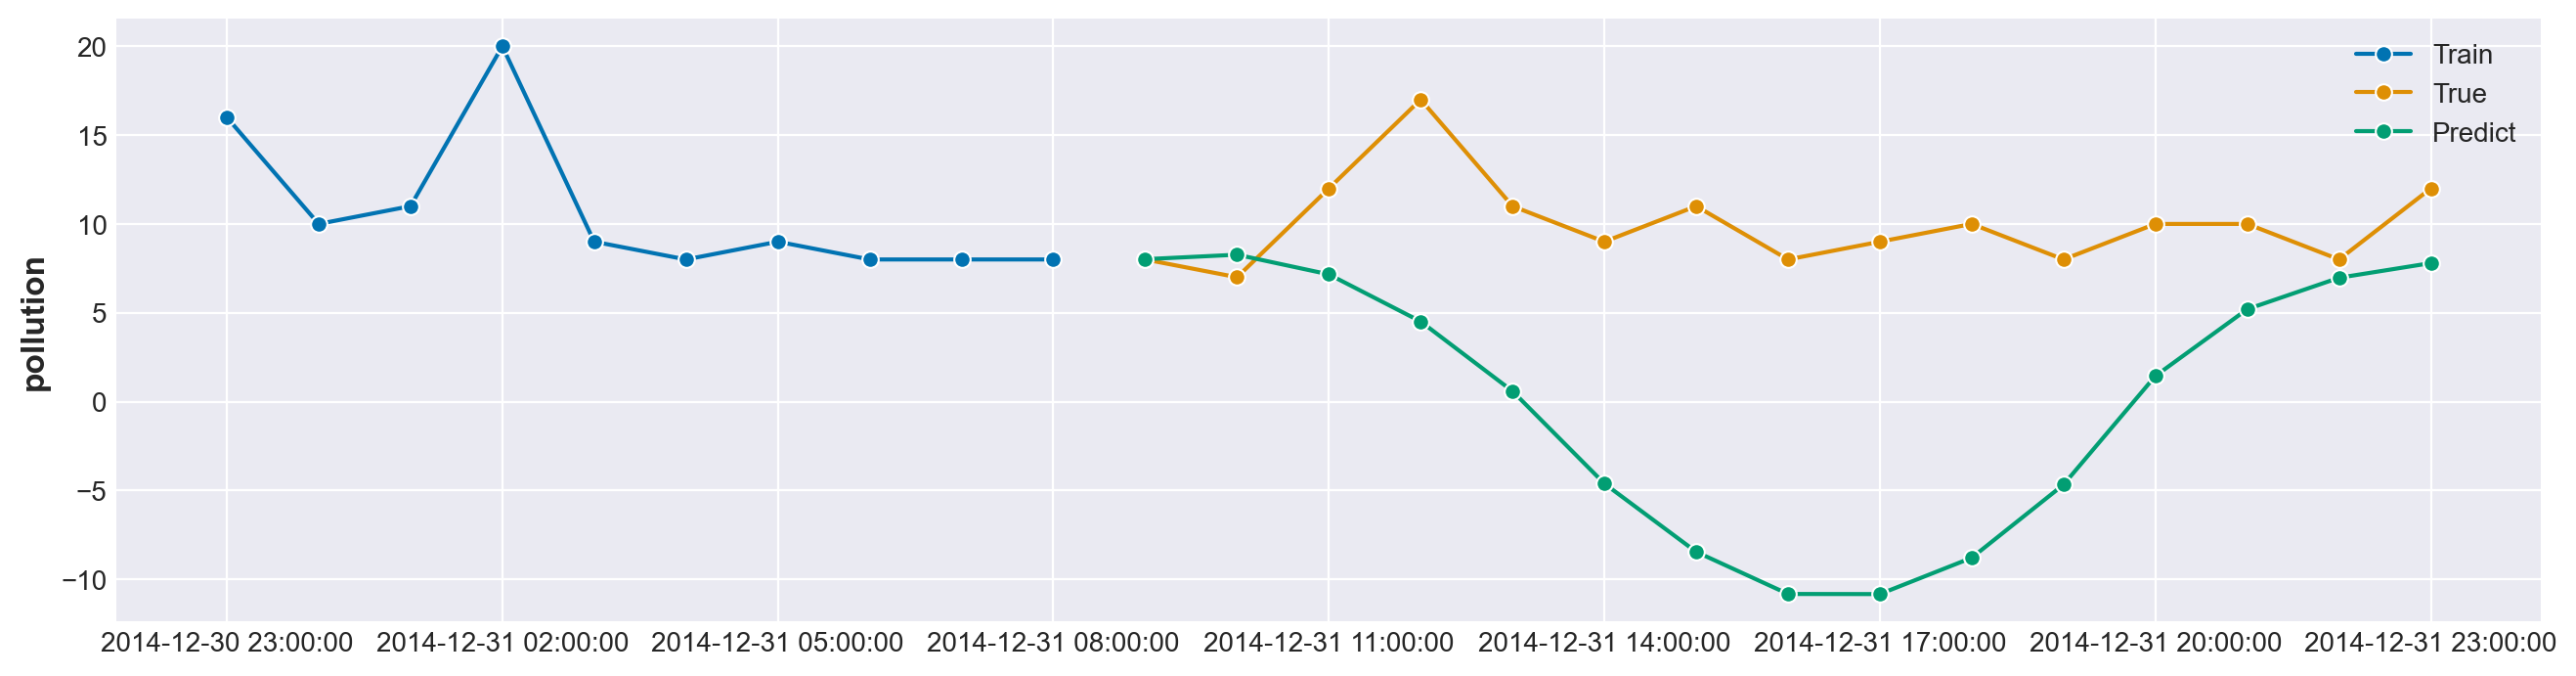

In [10]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [11]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

(128, 5)


,mean_test_MeanAbsoluteError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsoluteError
0,67.931317,1.687057,1.127813,{'forecaster__deseasonalizer__model': 'additiv...,58.5
1,67.805233,1.671792,1.362394,{'forecaster__deseasonalizer__model': 'additiv...,50.5
2,66.908801,1.592770,1.253527,{'forecaster__deseasonalizer__model': 'additiv...,14.5
3,67.322953,1.694057,1.367352,{'forecaster__deseasonalizer__model': 'additiv...,42.5
4,67.931317,1.602170,1.372759,{'forecaster__deseasonalizer__model': 'additiv...,58.5


### Backtesting Insample Prediction

In [12]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)

losses = [
    MeanSquaredError(),
    MeanSquaredError(square_root=True),
    MeanAbsoluteError(),
    MeanAbsolutePercentageError(),
    MeanAbsolutePercentageError(symmetric=False),
    MeanAbsoluteScaledError(),
]

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    scoring=losses,
    return_data=True,
)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,test_MeanAbsoluteScaledError
0,116.545109,3.429238,0.622016,43710,2014-12-28 05:00:00,2010-01-02 00:00:00 129.0 2010-01-02 01:00:...,Date_Time 2014-12-28 06:00:00 264.0 2014-12...,2014-12-28 06:00:00 263.806267 2014-12-28 0...,103.412002,1.988844,8.370358
1,118.139160,3.510292,0.576912,43725,2014-12-28 20:00:00,2010-01-02 00:00:00 129.0 2010-01-02 01:00:...,Date_Time 2014-12-28 21:00:00 293.0 2014-12...,2014-12-28 21:00:00 188.290880 2014-12-28 2...,91.046181,0.288147,7.366205
2,57.477553,3.831008,0.593243,43740,2014-12-29 11:00:00,2010-01-02 00:00:00 129.0 2010-01-02 01:00:...,Date_Time 2014-12-29 12:00:00 56.0 2014-12...,2014-12-29 12:00:00 127.117181 2014-12-29 1...,48.433234,1.298667,3.916453
3,41.683379,3.141189,0.686082,43755,2014-12-30 02:00:00,2010-01-02 00:00:00 129.0 2010-01-02 01:00:...,Date_Time 2014-12-30 03:00:00 28.0 2014-12-...,2014-12-30 03:00:00 78.355816 2014-12-30 04...,33.613477,2.156389,2.716882
4,56.722284,3.572551,0.603826,43770,2014-12-30 17:00:00,2010-01-02 00:00:00 129.0 2010-01-02 01:00:...,Date_Time 2014-12-30 18:00:00 79.0 2014-12-...,2014-12-30 18:00:00 68.222069 2014-12-30 19...,54.669083,4.926694,4.418922


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

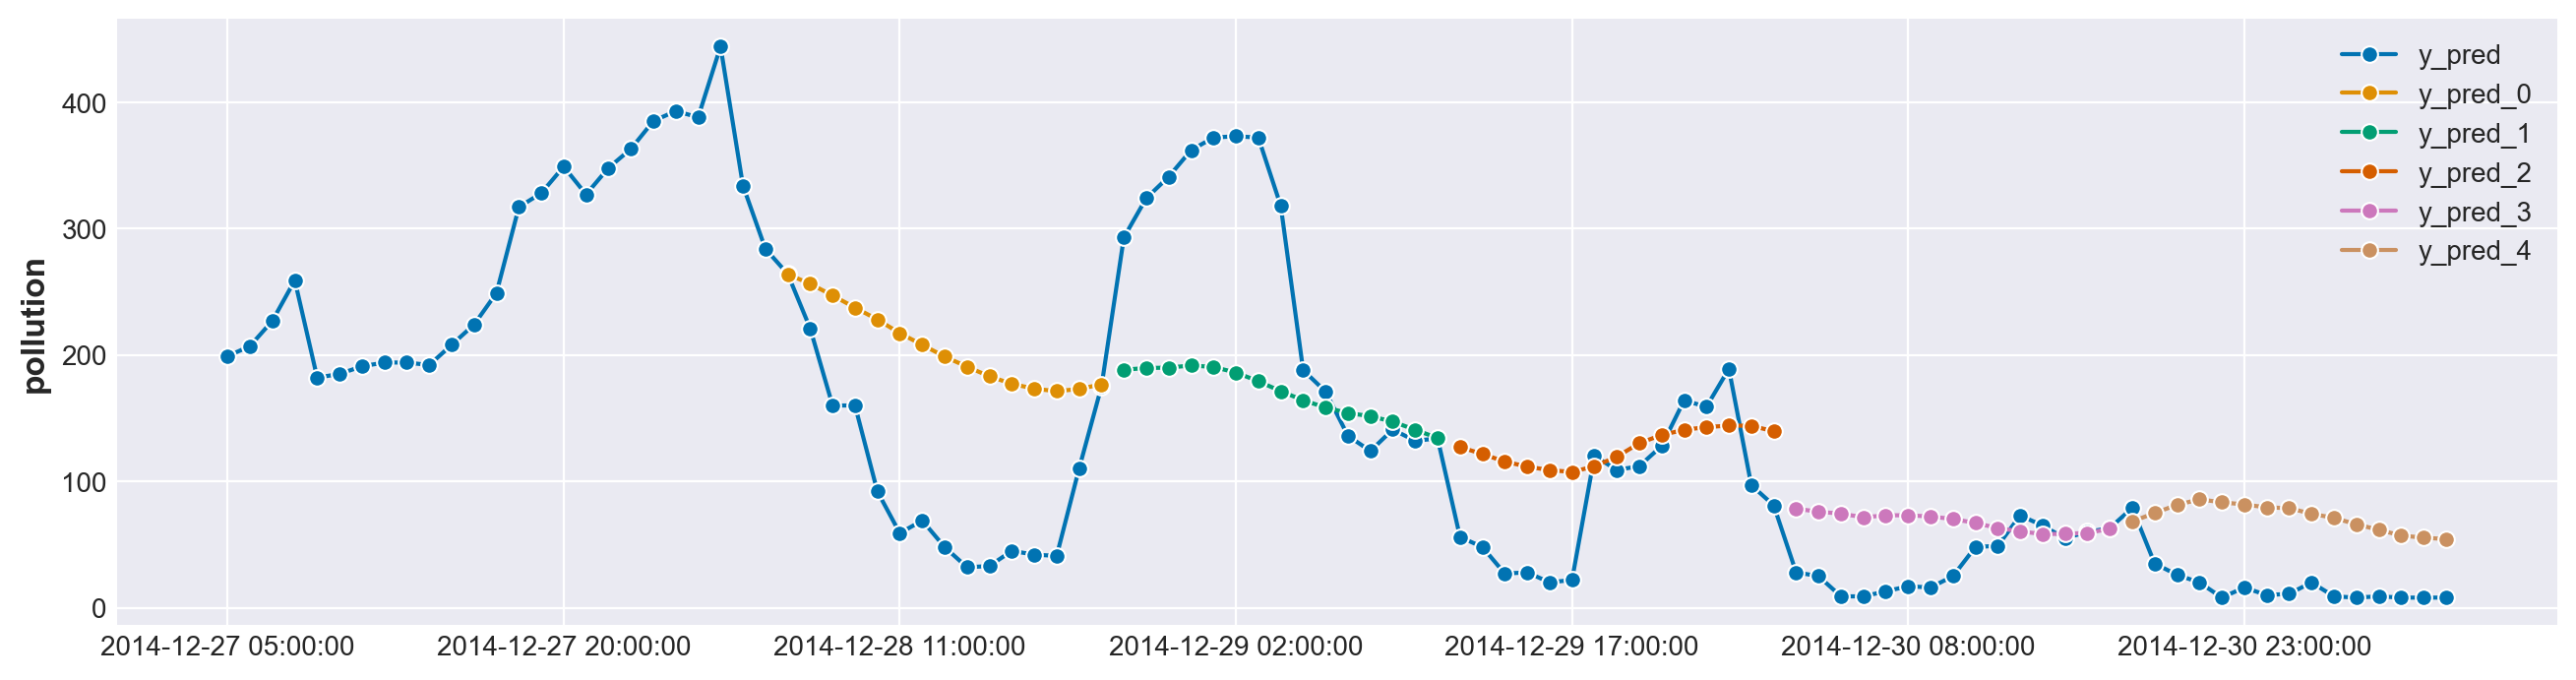

In [13]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

### Get best model Parameters

In [14]:
gscv.best_forecaster_.get_fitted_params()

{'forecaster': TransformedTargetForecaster(steps=[('imputer_y',
                                     Imputer(method='ffill', random_state=80)),
                                    ('deseasonalizer',
                                     ConditionalDeseasonalizer(sp=24)),
                                    ('detrender',
                                     Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
                                    ('reducer',
                                     RecursiveTabularRegressionForecaster(estimator=LassoLars(alpha=0.01, eps=0.0001, fit_intercept=False, random_state=80),
                                                                          pooling='global',
                                                                          window_length=24))]),
 'steps': [('x_transforner',
   TransformerPipeline(steps=[('imputer_x',
                               Imputer(method='ffill', random_state=80))])),
  ('scaler_x',
   OptionalPassthrough(p

### Train Model Parameter

In [15]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__coef"
]
model_intercept = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_coeff {model_coeff}", end="\n\n")
print(f"model_intercept {model_intercept}", end="\n\n")

model_n_features_in 30

model_fname_in ['pollution_lag_1' 'pollution_lag_2' 'pollution_lag_3' 'pollution_lag_4'
 'pollution_lag_5' 'pollution_lag_6' 'pollution_lag_7' 'pollution_lag_8'
 'pollution_lag_9' 'pollution_lag_10' 'pollution_lag_11'
 'pollution_lag_12' 'pollution_lag_13' 'pollution_lag_14'
 'pollution_lag_15' 'pollution_lag_16' 'pollution_lag_17'
 'pollution_lag_18' 'pollution_lag_19' 'pollution_lag_20'
 'pollution_lag_21' 'pollution_lag_22' 'pollution_lag_23'
 'pollution_lag_24' 'dewp' 'temp' 'press' 'wnd_spd' 'snow' 'rain']

model_coeff [ 1.11393904e+00 -1.71014318e-01 -7.70287654e-03  2.03914177e-02
 -8.84794327e-03 -9.33974218e-03  5.24132849e-03 -1.22259863e-02
  1.02490860e-02 -7.02044390e-03  1.20141616e-02 -6.32008599e-03
  5.41290981e-03 -4.60820188e-03 -6.02772857e-04  5.23747061e-03
  2.47462563e-03  3.32291990e-03  3.01515259e-03 -1.30372703e-03
  1.35349090e-02 -1.57715811e-02  1.66587772e-02 -1.46317786e-02
  2.75414317e-01 -3.27669771e-01  4.06562830e-03 -1.7113

### model cutoff

In [16]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

DatetimeIndex(['2014-12-31 08:00:00'], dtype='datetime64[ns]', name='Date_Time', freq='H') 2014-12-31 08:00:00


### Model Cloning

In [17]:
from sklearn.base import clone

model = clone(gscv.best_forecaster_).set_params(**gscv.best_params_)

dir(model)

['_X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rpow__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_anytag_notnone_set',
 '_anytag_notnone_val',
 '_anytagis',
 '_anytagis_then_set',
 '_check_X',
 '_check_X_y',
 '_check_estimators',
 '_check_fh',
 '_check_names',
 '_check_steps',
 '_clone_flags',
 '_coerce_estimator_tuple',
 '_components',
 '_config',
 '_config_dynamic',
 '_converter_store_y',
 '_cutoff',
 '_dunder_concat',
 '_fh',
 '_fit',
 '_get_class_flag',
 '_get_class_flags',
 '_get_estimator_list',
 '_get_estimator_names',
 '_get_estimator_tuples',
 '_get_fitted_params',
 '_get_fitted_params_defa

### Model saving 

In [18]:
# gscv.best_forecaster_.save("../results/elastic_net")

import joblib

joblib.dump(gscv.best_forecaster_, "../results/LassoLars.pkl")

['../results/LassoLars.pkl']

### Features importance

<Axes: >

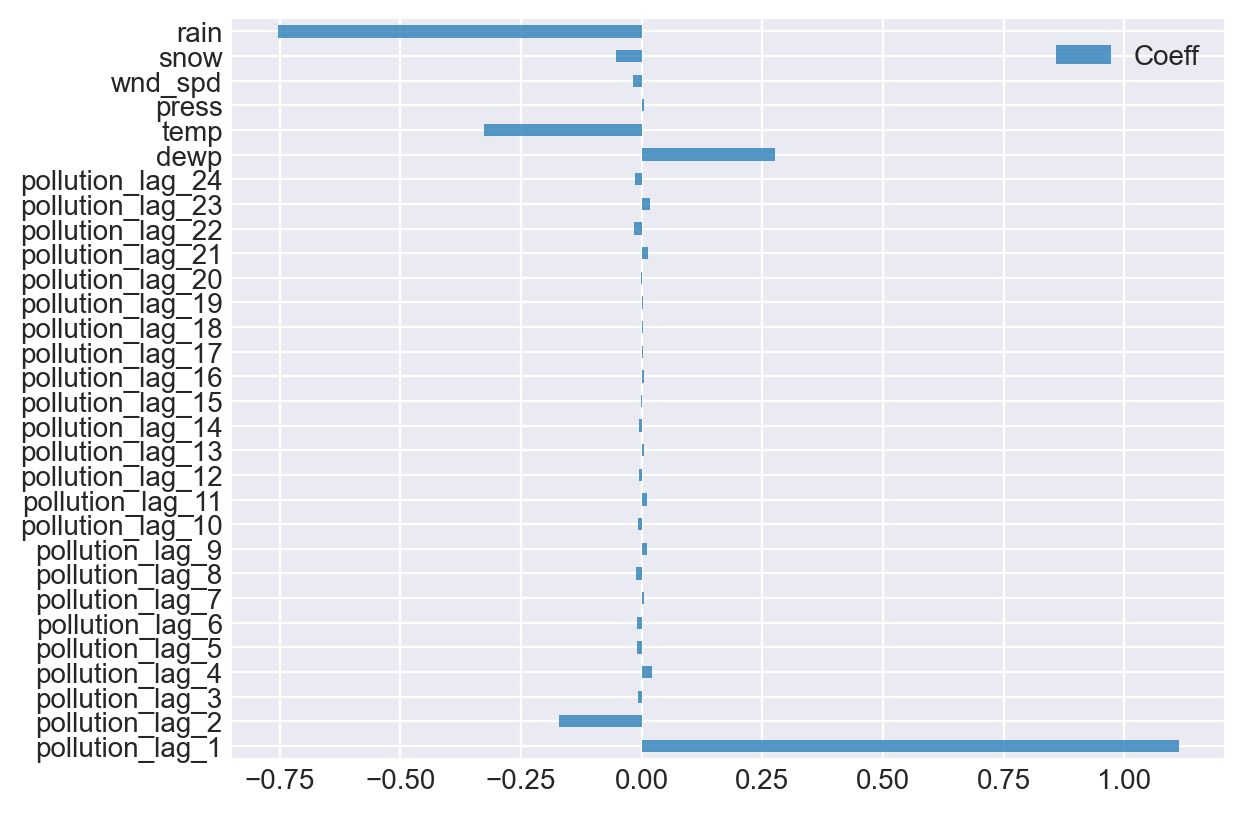

In [19]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)